# Hands-on Day 4

## You'll learn

### ML methods

- Gradient Boosting Trees with xgboost

### ML techniques
- hyperparameter optimisation
- ROC curves

# Initial setup 

- read in parquet file
- create x,y vectors from panda dataframe

In [1]:
%reload_ext custom_functions
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Check out these custom functions
from custom_functions import *

In [3]:
inputFile = "file:///home/jovyan/Higgs100k.parquet"
# inputFile = 'file:///home/jovyan/Higgs1M.parquet'
# inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = pd.read_parquet(inputFile)

CPU times: user 281 ms, sys: 172 ms, total: 453 ms
Wall time: 268 ms


In [4]:
# The first column is the target variable
y = df.iloc[:, 0]  # df with label
x = df.iloc[:, 1:]  # df with all other variables

len(x)

99999

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [6]:
# sanity check

print(len(x_train) + len(x_test))
print(len(y_train) + len(y_test))

99999
99999


# ML model: GBT

- xgboost uses the parameter n_jobs to spawn multi-core jobs on the SAME machine
- do not abuse it or you'll eat up all resources (set it to 5 max)

In [7]:
# DO NOT Use all available cores NJOBS = -1
NJOBS = 5

In [8]:
!nproc

56


In [10]:
!pip install xgboost

In [11]:
import xgboost as xgb

# Define the XGBoost classifier with multi-core support
gbt = xgb.XGBClassifier(
    n_estimators=100,  # Number of trees (can be adjusted)
    max_depth=6,  # Maximum depth of each tree (can be tuned)
    learning_rate=0.1,  # Learning rate (can be tuned)
    n_jobs=NJOBS,  # DO NOT Use all available cores
    verbosity=1,  # Set verbosity level to monitor training progress
)


In [12]:
# Train the model
%time gbt.fit(x_train, y_train)


CPU times: user 4.74 s, sys: 88.7 ms, total: 4.83 s
Wall time: 693 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=5,
              num_parallel_tree=None, random_state=None, ...)

In [14]:
# Make predictions on the test set
%time y_pred = gbt.predict(x_test)

CPU times: user 127 ms, sys: 1.61 ms, total: 128 ms
Wall time: 33 ms


In [15]:
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(
    y_test, y_pred, average="binary"
)  # For binary classification
recall = recall_score(y_test, y_pred, average="binary")
f1 = f1_score(y_test, y_pred, average="binary")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7294
Precision: 0.7437
Recall: 0.7498
F1-Score: 0.7467


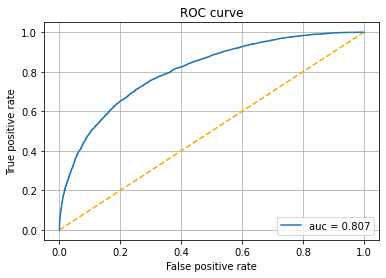

In [16]:
# Get predicted probabilities for the positive class
y_scores = gbt.predict_proba(x_test)[:, 1]

# make ROC curve
drawROC2(y_test, y_scores)

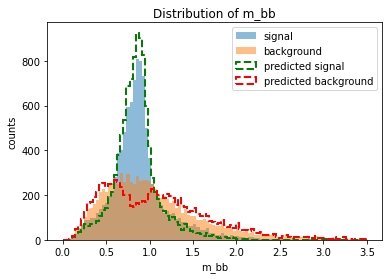

In [17]:
# plot signal vs background with prediction
variable = "m_bb"
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

Feature Importance Ranking:
                     Feature  Importance
25                      m_bb    0.159220
26                     m_wbb    0.095197
27                    m_wwbb    0.087621
5                    jet1_pt    0.068382
22                     m_jjj    0.068179
24                     m_jlv    0.058946
8                 jet1_b-tag    0.052134
3   missing_energy_magnitude    0.037450
21                      m_jj    0.036863
0                  lepton_pT    0.034664
9                    jet2_pt    0.031197
16                jet3_b-tag    0.025195
20                jet4_b-tag    0.021892
23                      m_lv    0.021795
13                   jet3_pt    0.021421
17                   jet4_pt    0.020732
12                jet2_b-tag    0.020010
6                   jet1_eta    0.015013
1                 lepton_eta    0.014815
10                  jet2_eta    0.013962
14                  jet3_eta    0.013611
18                   je4_eta    0.012752
11                  jet2_phi 

<Figure size 720x432 with 0 Axes>

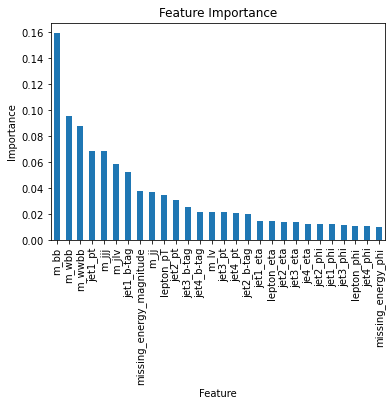

In [18]:
# draw feature importance
drawFeaturesXgb(x, gbt)

# Hyperparameter scan

In [19]:
# Get the default hyperparameters
default_params = gbt.get_params()

# Print the default hyperparameters
for param, value in default_params.items():
    print(f"{param}: {value}")

objective: binary:logistic
base_score: None
booster: None
callbacks: None
colsample_bylevel: None
colsample_bynode: None
colsample_bytree: None
device: None
early_stopping_rounds: None
enable_categorical: False
eval_metric: None
feature_types: None
gamma: None
grow_policy: None
importance_type: None
interaction_constraints: None
learning_rate: 0.1
max_bin: None
max_cat_threshold: None
max_cat_to_onehot: None
max_delta_step: None
max_depth: 6
max_leaves: None
min_child_weight: None
missing: nan
monotone_constraints: None
multi_strategy: None
n_estimators: 100
n_jobs: 5
num_parallel_tree: None
random_state: None
reg_alpha: None
reg_lambda: None
sampling_method: None
scale_pos_weight: None
subsample: None
tree_method: None
validate_parameters: None
verbosity: 1


## Exercise 1

- do hyperparameter optimisation using Randomized Grid search
- select a reasonable number and range of hyperparameters
- DO NOT USE all possible cores (check sklearn doc)
- while the code runs, check with top that there are indeed several python processes running
- check metrics (accuracy, ROC curve, signal vs background, feature ranking)

In [20]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize the model
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",
)

# Define the parameter distribution
param_dist = {
    "n_estimators": [20, 50, 100, 200, 300, 500],
    "learning_rate": [0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
    "max_depth": [3, 5, 7, 10, 15],
    "subsample": [0.4, 0.6, 0.8, 1.0],
    "colsample_bytree": [0.4, 0.6, 0.8, 1.0],
}

In [21]:
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=3,
    n_jobs=NJOBS,
    verbose=1,
    random_state=42,
)

In [22]:
# Run random search
%time random_search.fit(x_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:28:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: user 4min 21s, sys: 2.38 s, total: 4min 24s
Wall time: 1min 23s


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           multi_strategy=None,
                               

In [23]:
# Best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy: ", random_search.best_score_)

Best parameters found:  {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.4}
Best accuracy:  0.7209089961189855


In [24]:
# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

In [25]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(
    y_test, y_pred, average="binary"
)  # For binary classification
recall = recall_score(y_test, y_pred, average="binary")
f1 = f1_score(y_test, y_pred, average="binary")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7294
Precision: 0.7427
Recall: 0.7520
F1-Score: 0.7473


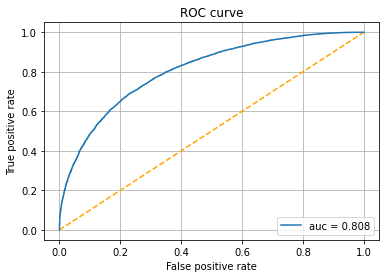

In [26]:
# Get predicted probabilities for the positive class
y_scores = best_model.predict_proba(x_test)[:, 1]

# make ROC curve
drawROC2(y_test, y_scores)

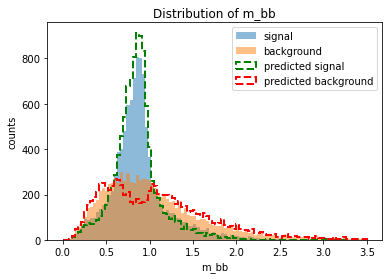

In [27]:
# plot signal vs background with prediction
variable = "m_bb"
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

## Exercise 2

- Run the best model on full dataset

In [28]:
inputFile = "file:///home/jovyan/Higgs10M.parquet"

%time df = pd.read_parquet(inputFile)

CPU times: user 9.17 s, sys: 5.7 s, total: 14.9 s
Wall time: 976 ms


In [29]:
# create train/test set
y = df.iloc[:, 0]  # df with label
x = df.iloc[:, 1:]  # df with all other variables

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)
len(y)

10000000

In [30]:
# Define the XGBoost classifier with multi-core support
best_gbt = xgb.XGBClassifier(
    n_estimators=random_search.best_params_["n_estimators"],  # Number of trees
    max_depth=random_search.best_params_["max_depth"],  # Maximum depth of each tree
    learning_rate=random_search.best_params_["learning_rate"],  # Learning rate
    subsample=random_search.best_params_["subsample"],
    colsample_bytree=random_search.best_params_["colsample_bytree"],
    n_jobs=NJOBS,  # DO NOT Use all available cores
    verbosity=1,  # Set verbosity level to monitor training progress
)


In [31]:
# Train the model
%time best_gbt.fit(x_train, y_train)


CPU times: user 15min 48s, sys: 33.3 s, total: 16min 22s
Wall time: 3min 21s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=5,
              num_parallel_tree=None, random_state=None, ...)

In [32]:
# Make predictions on the test set
y_pred = best_gbt.predict(x_test)

In [33]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(
    y_test, y_pred, average="binary"
)  # For binary classification
recall = recall_score(y_test, y_pred, average="binary")
f1 = f1_score(y_test, y_pred, average="binary")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7481
Precision: 0.7582
Recall: 0.7702
F1-Score: 0.7641


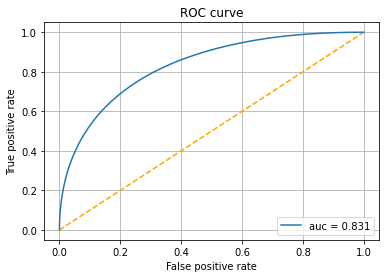

In [34]:
# Get predicted probabilities for the positive class
y_scores = best_gbt.predict_proba(x_test)[:, 1]

# make ROC curve
drawROC2(y_test, y_scores)

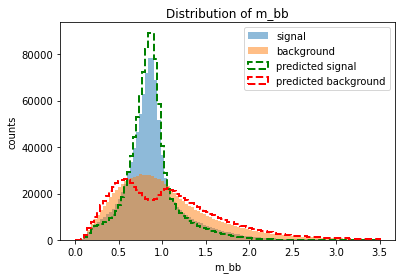

In [35]:
# plot signal vs background with prediction
variable = "m_bb"
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

Feature Importance Ranking:
                     Feature  Importance
25                      m_bb    0.200877
27                    m_wwbb    0.096976
26                     m_wbb    0.092662
22                     m_jjj    0.082042
5                    jet1_pt    0.062548
24                     m_jlv    0.061336
8                 jet1_b-tag    0.047085
0                  lepton_pT    0.044292
21                      m_jj    0.040464
3   missing_energy_magnitude    0.033522
20                jet4_b-tag    0.032454
9                    jet2_pt    0.030745
12                jet2_b-tag    0.029747
16                jet3_b-tag    0.025387
13                   jet3_pt    0.019000
23                      m_lv    0.018418
17                   jet4_pt    0.016591
6                   jet1_eta    0.012132
1                 lepton_eta    0.011122
10                  jet2_eta    0.008430
18                   je4_eta    0.007635
14                  jet3_eta    0.007480
7                   jet1_phi 

<Figure size 720x432 with 0 Axes>

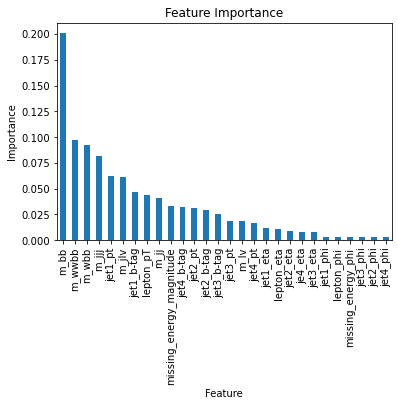

In [36]:
# draw feature importance
drawFeaturesXgb(x, best_gbt)